# Word Frequency & Topics Analysis of Donald Trump Rally Speeches

This notebook performs comprehensive word frequency analysis and visualization of Donald Trump's rally speeches from 2019-2020.

## Analysis Overview
- **Single word frequency analysis**: Most commonly used words
- **Bigram analysis**: Most common two-word phrases
- **Trigram analysis**: Most common three-word phrases
- **Temporal analysis**: Word usage patterns over time

## Import Libraries

Loading required libraries for text processing, visualization, and analysis.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import os
import re
import seaborn as sns
from tqdm.notebook import tqdm
from pathlib import Path
from typing import List, Tuple, Dict

import nltk
from nltk import sent_tokenize, word_tokenize, everygrams
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter

# Set consistent styling
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ksbon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ksbon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ksbon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Load and Parse Data

Loading all rally speech transcripts from the data directory and extracting metadata (location, month, year) from filenames.

In [16]:
def load_speech_data(data_dir: str = "../data/Donald Trump Rally Speeches") -> pd.DataFrame:
    """
    Load all speech transcripts and extract metadata from filenames.
    
    Parameters:
        data_dir: Path to directory containing speech text files
        
    Returns:
        DataFrame with columns: Location, Month, Year, filename, content, date
    """
    filenames, file_contents, years, months, locations = [], [], [], [], []
    data_path = Path(data_dir)
    
    # Get list of files with progress bar
    files = list(data_path.glob("*.txt"))
    
    for file_path in tqdm(files, desc="Loading speeches"):
        filename = file_path.name
        filenames.append(filename)
        
        # Read file content with error handling
        try:
            with open(file_path, encoding="utf-8") as file:
                file_contents.append(file.read())
        except Exception as e:
            print(f"Error reading {filename}: {e}")
            file_contents.append("")
        
        # Extract metadata from filename
        years.append(filename[-8:-4])
        match = re.search(r"([A-z]+)([A-z]{3})([0-9]+)\_", filename)
        if match:
            months.append(match.group(2))
            # Add spaces before capital letters for location names
            location_raw = match.group(1)
            locations.append(''.join([' ' + c if c.isupper() else c for c in location_raw]).strip())
        else:
            months.append("Unknown")
            locations.append("Unknown")
    
    # Create DataFrame
    df = pd.DataFrame({
        'Location': locations,
        'Month': months,
        'Year': years,
        'filename': filenames,
        'content': file_contents
    })
    
    # Convert to datetime for better temporal analysis
    month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
                 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
    
    df['Month_Num'] = df['Month'].map(month_map)
    df['Date'] = pd.to_datetime(df['Year'] + '-' + df['Month_Num'].astype(str) + '-15')
    df = df.sort_values('Date').reset_index(drop=True)
    
    # Add word count
    df['word_count'] = df['content'].apply(lambda x: len(x.split()))
    
    return df

# Load the data
df = load_speech_data()
print(f"Loaded {len(df)} speeches from {df['Year'].min()} to {df['Year'].max()}")
print(f"Total words: {df['word_count'].sum():,}")

Loading speeches:   0%|          | 0/35 [00:00<?, ?it/s]

Loaded 35 speeches from 2019 to 2020
Total words: 370,477


In [17]:
# Display dataset overview
print("Dataset Overview:")
print(f"{'='*60}")
df.head(10)

Dataset Overview:


,Location,Month,Year,filename,content,Month_Num,Date,word_count
0,Greenville,Jul,2019,GreenvilleJul17_2019.txt,Thank you very much. Thank you. Thank you. Tha...,7,2019-07-15,10605
1,Cincinnati,Aug,2019,CincinnatiAug1_2019.txt,Thank you all. Thank you very much. Thank you ...,8,2019-08-15,8170
2,New Hampshire,Aug,2019,NewHampshireAug15_2019.txt,Thank you very much everybody. Thank you. Wow...,8,2019-08-15,10141
3,Texas,Sep,2019,TexasSep23_2019.txt,"Hello, Houston. I am so thrilled to be here in...",9,2019-09-15,2487
4,New Mexico,Sep,2019,NewMexicoSep16_2019.txt,"Wow, thank you. Thank you, New Mexico. Thank ...",9,2019-09-15,11498
5,Fayetteville,Sep,2019,FayettevilleSep9_2019.txt,Thank you everybody. Thank you and Vice Presi...,9,2019-09-15,9199
6,Dallas,Oct,2019,DallasOct17_2019.txt,Thank you. Thank you very much. Hello Dallas. ...,10,2019-10-15,10501
7,Minneapolis,Oct,2019,MinneapolisOct10_2019.txt,"Thank you very much. Thank you, Minnesota. Thi...",10,2019-10-15,11647
8,Tupelo,Nov,2019,TupeloNov1_2019.txt,"ell, thank you very much. And hello, Tupelo. T...",11,2019-11-15,9268
9,Lexington,Nov,2019,LexingtonNov4_2019.txt,Thank you very much and thank you to the origi...,11,2019-11-15,8950


In [18]:
# Dataset statistics
print("Dataset Statistics:")
print(f"{'='*60}")
print(df[['word_count', 'Year']].groupby('Year').agg({
    'word_count': ['count', 'sum', 'mean', 'min', 'max']
}).round(0))

# Create interactive timeline
fig = px.scatter(df, x='Date', y='word_count', 
                 hover_data=['Location', 'Month', 'Year'],
                 title='Speech Word Count Over Time',
                 labels={'word_count': 'Word Count', 'Date': 'Date'},
                 color='Year',
                 size='word_count',
                 color_discrete_sequence=px.colors.qualitative.Set2)

fig.update_layout(height=400, showlegend=True)
fig.show()

Dataset Statistics:
     word_count                              
          count     sum     mean   min    max
Year                                         
2019         12  120116  10010.0  2487  17831
2020         23  250361  10885.0  6303  16900


In [19]:
# Storing the dataframe for use in other notebooks
DT_rally_speaches_dataset = df
%store DT_rally_speaches_dataset

Stored 'DT_rally_speaches_dataset' (DataFrame)


## Most commonly used words

## Utility Functions

Helper functions for text processing and word cloud generation.

In [20]:
def generate_wordcloud(text: str, stopwords: set, title: str = "Word Cloud",
                      max_words: int = 200, width: int = 1600, height: int = 800,
                      background_color: str = "white") -> plt.Figure:
    """
    Generate a word cloud visualization from text.
    
    Parameters:
        text: Input text to visualize
        stopwords: Set of words to exclude
        title: Plot title
        max_words: Maximum number of words to display
        width: Image width in pixels
        height: Image height in pixels
        background_color: Background color
        
    Returns:
        matplotlib Figure object
    """
    wordcloud = WordCloud(
        stopwords=stopwords,
        max_words=max_words,
        width=width,
        height=height,
        background_color=background_color,
        colormap='viridis',
        relative_scaling=0.5,
        min_font_size=10
    ).generate(text)
    
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title, fontsize=20, fontweight='bold', pad=20)
    ax.axis("off")
    plt.tight_layout(pad=0)
    
    return fig


def get_ngrams(text: str, n: int, stopwords: set, top_k: int = 50) -> Counter:
    """
    Extract n-grams from text and return frequency counts.
    
    Parameters:
        text: Input text
        n: Size of n-grams (1 for unigrams, 2 for bigrams, etc.)
        stopwords: Set of words to exclude
        top_k: Number of top n-grams to return
        
    Returns:
        Counter object with n-gram frequencies
    """
    # Clean text
    text = re.sub(r'\W+', ' ', text)
    tokenized_text = word_tokenize(text.lower())
    
    # Filter stopwords
    words = [w for w in tokenized_text if w.lower() not in stopwords and len(w) > 2]
    
    # Generate n-grams
    ngrams = []
    for ngram in list(everygrams(words, n, n)):
        ngrams.append(" ".join(ngram))
    
    return Counter(ngrams).most_common(top_k)


def plot_top_ngrams(counter_data: List[Tuple[str, int]], title: str, 
                    n_display: int = 20, color: str = '#1f77b4') -> None:
    """
    Create an interactive bar plot of top n-grams using Plotly.
    
    Parameters:
        counter_data: List of (ngram, count) tuples
        title: Plot title
        n_display: Number of items to display
        color: Bar color
    """
    ngrams, counts = zip(*counter_data[:n_display])
    
    fig = go.Figure(data=[
        go.Bar(x=list(counts), y=list(ngrams), orientation='h',
               marker=dict(color=color),
               text=counts,
               textposition='outside')
    ])
    
    fig.update_layout(
        title=title,
        xaxis_title="Frequency",
        yaxis_title="",
        height=max(400, n_display * 25),
        yaxis={'categoryorder': 'total ascending'},
        showlegend=False,
        template='plotly_white'
    )
    
    fig.show()

In [21]:
# Configure stopwords and custom words to filter
custom_stopwords = set(stopwords.words('english'))
# Add common words that don't add meaning to political speeches
custom_stopwords.update(['going', 'really', 'know', 'get', 'got', 'say', 'said', 
                         'one', 'two', 'three', 'would', 'could', 'look', 'like'])

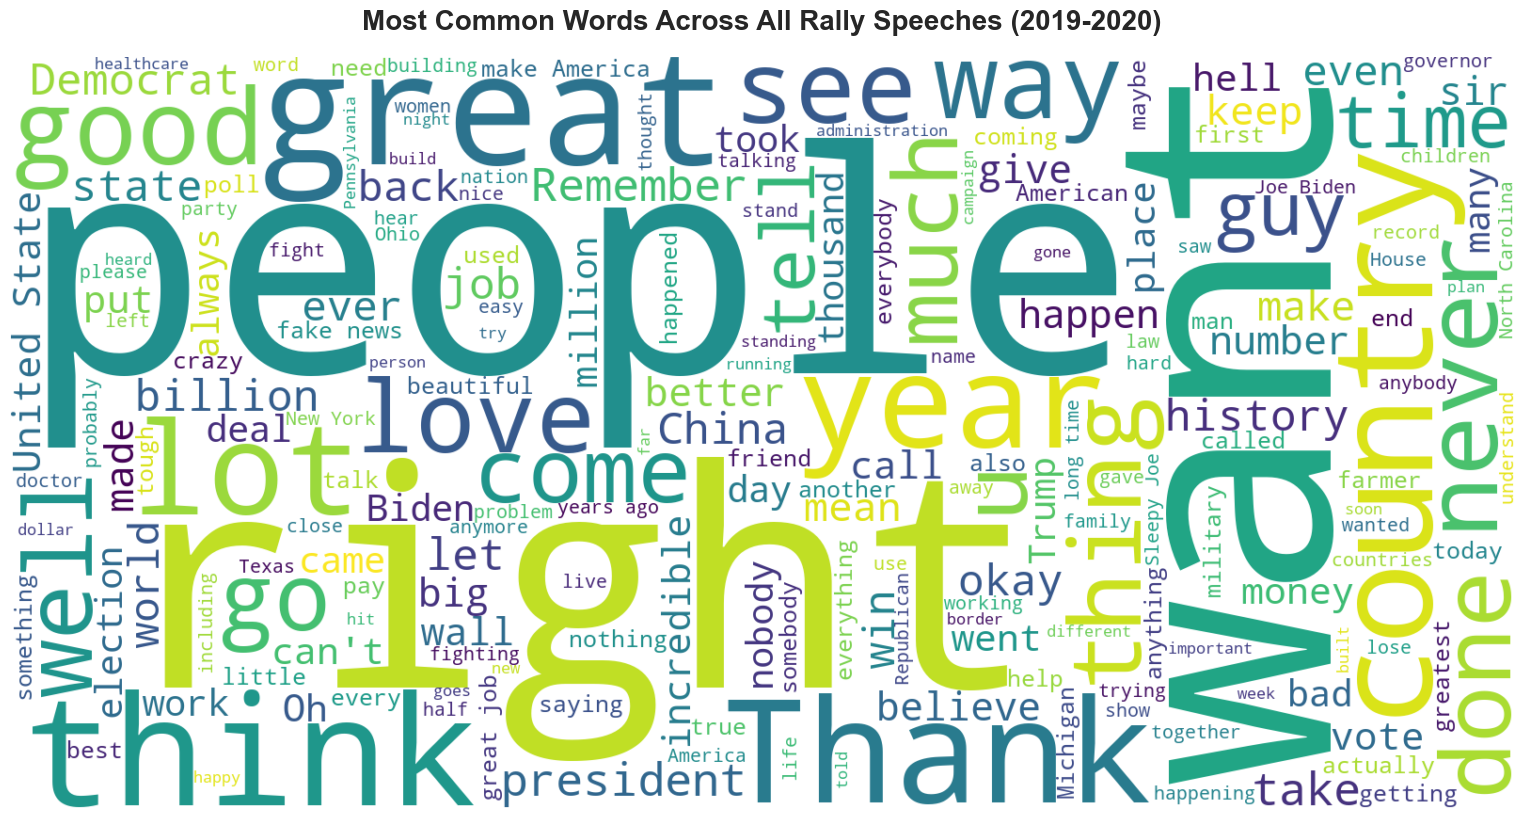

In [22]:
# Combine all speech content
all_text = " ".join(content for content in df['content'])

# Generate word cloud
fig = generate_wordcloud(
    all_text, 
    custom_stopwords, 
    title="Most Common Words Across All Rally Speeches (2019-2020)",
    max_words=200
)
plt.show()

# Get top words for bar chart
top_words = get_ngrams(all_text, n=1, stopwords=custom_stopwords, top_k=30)
plot_top_ngrams(top_words, "Top 30 Most Frequent Words", n_display=30, color='#2ca02c')

## Most common two word sentences

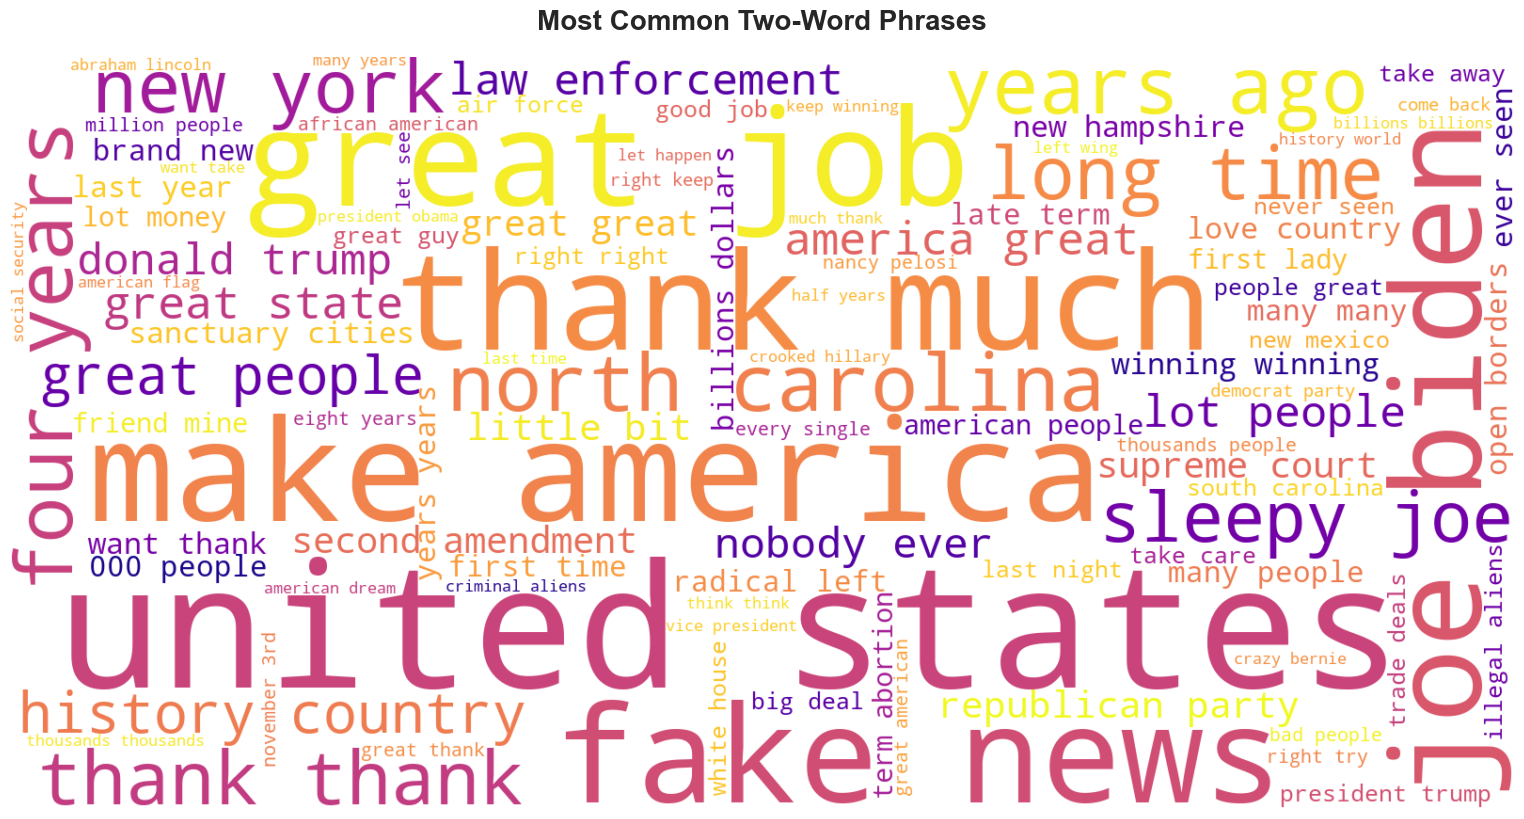

In [23]:
# Get bigrams from all speeches
bigrams = get_ngrams(all_text, n=2, stopwords=custom_stopwords, top_k=100)

# Generate bigram word cloud
bigram_dict = dict(bigrams)
wordcloud = WordCloud(
    width=1600, 
    height=800,
    background_color="white",
    colormap='plasma',
    max_words=100,
    relative_scaling=0.5
).generate_from_frequencies(bigram_dict)

fig, ax = plt.subplots(figsize=(16, 8))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_title("Most Common Two-Word Phrases", fontsize=20, fontweight='bold', pad=20)
ax.axis("off")
plt.tight_layout(pad=0)
plt.show()

# Interactive bar chart
plot_top_ngrams(bigrams, "Top 25 Most Frequent Bigrams", n_display=25, color='#ff7f0e')

## Most common three word sentences

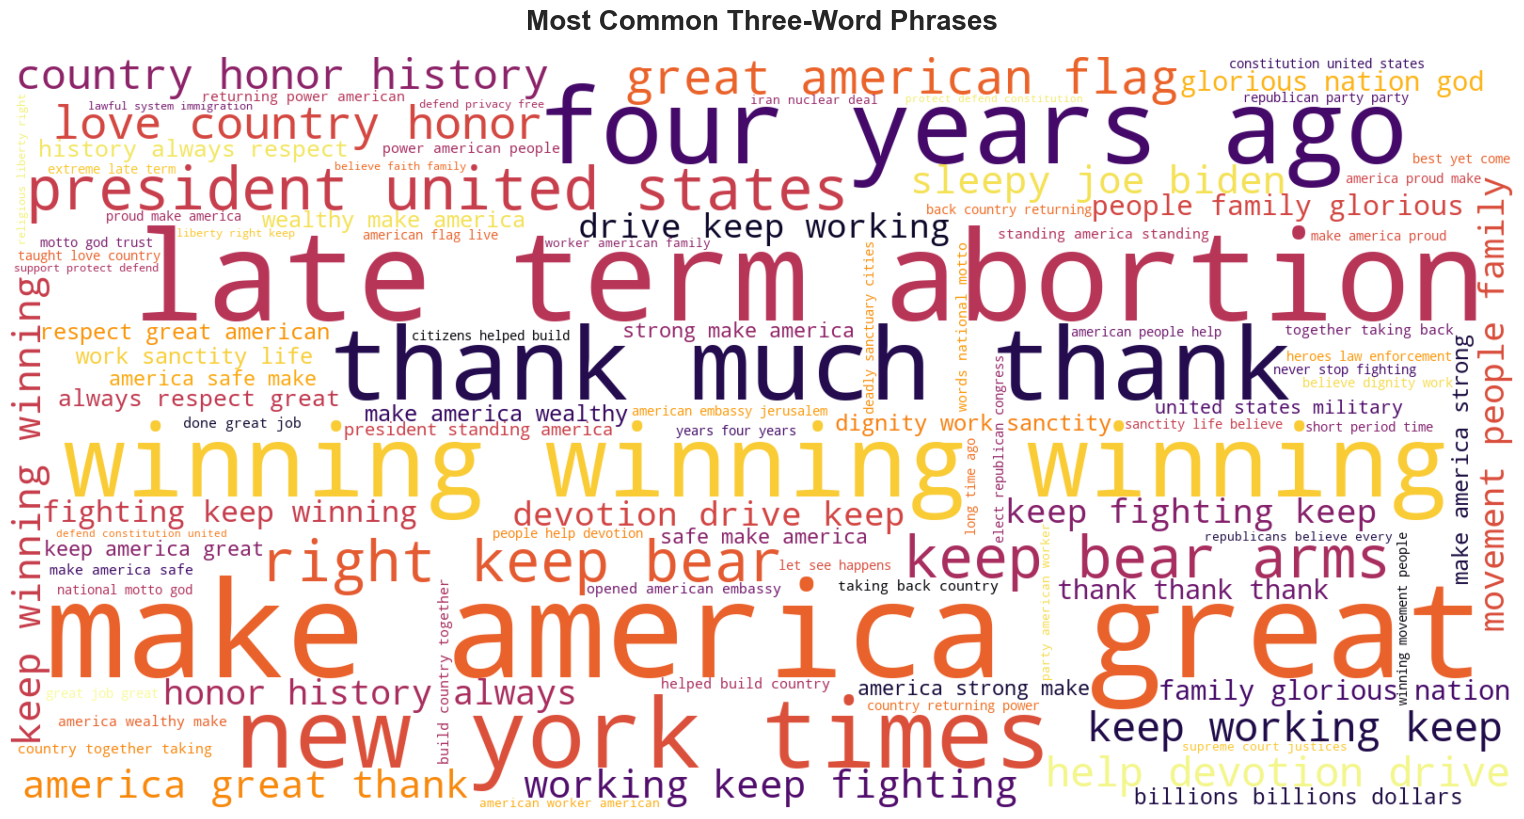

In [24]:
# Get trigrams from all speeches
trigrams = get_ngrams(all_text, n=3, stopwords=custom_stopwords, top_k=100)

# Generate trigram word cloud
trigram_dict = dict(trigrams)
wordcloud = WordCloud(
    width=1600,
    height=800,
    background_color="white",
    colormap='inferno',
    max_words=100,
    relative_scaling=0.5
).generate_from_frequencies(trigram_dict)

fig, ax = plt.subplots(figsize=(16, 8))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_title("Most Common Three-Word Phrases", fontsize=20, fontweight='bold', pad=20)
ax.axis("off")
plt.tight_layout(pad=0)
plt.show()

# Interactive bar chart
plot_top_ngrams(trigrams, "Top 20 Most Frequent Trigrams", n_display=20, color='#d62728')

## Temporal Analysis: Word Usage Over Time

Analyzing how word usage patterns changed between 2019 and 2020.

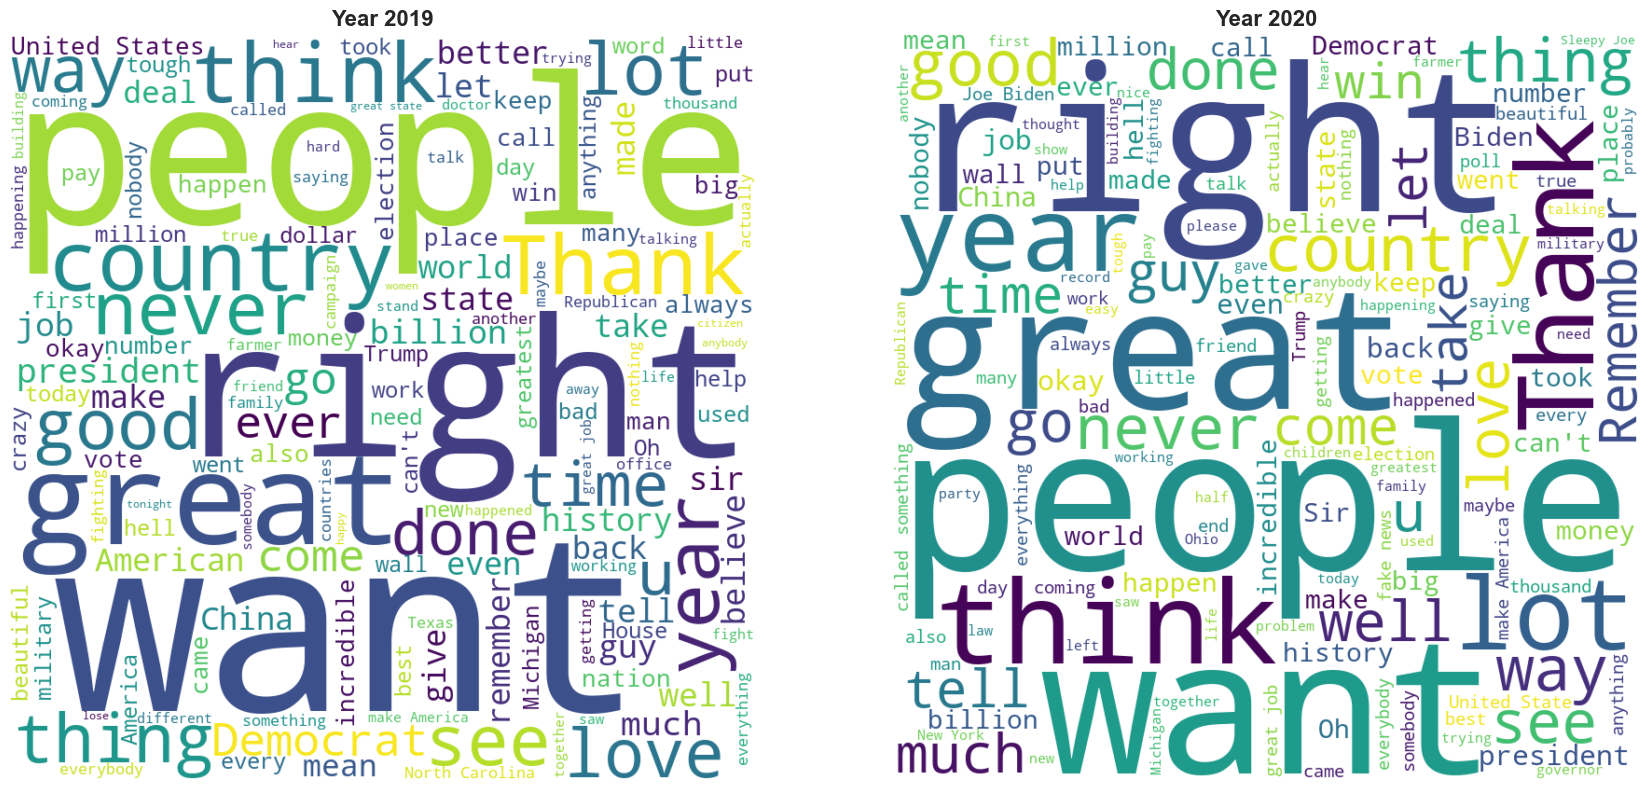

In [25]:
# Compare word clouds by year
years = df['Year'].unique()

fig, axes = plt.subplots(1, len(years), figsize=(18, 8))

for idx, year in enumerate(sorted(years)):
    year_text = " ".join(df[df['Year'] == year]['content'])
    
    wordcloud = WordCloud(
        stopwords=custom_stopwords,
        max_words=150,
        width=800,
        height=800,
        background_color="white",
        colormap='viridis',
        relative_scaling=0.5
    ).generate(year_text)
    
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'Year {year}', fontsize=16, fontweight='bold')
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

In [26]:
# Compare top words between years
comparison_data = []

for year in sorted(df['Year'].unique()):
    year_text = " ".join(df[df['Year'] == year]['content'])
    top_words_year = get_ngrams(year_text, n=1, stopwords=custom_stopwords, top_k=15)
    
    for word, count in top_words_year:
        comparison_data.append({
            'Year': year,
            'Word': word,
            'Count': count,
            'Speeches': len(df[df['Year'] == year])
        })

comparison_df = pd.DataFrame(comparison_data)

# Create interactive grouped bar chart
fig = px.bar(comparison_df, 
             x='Word', 
             y='Count', 
             color='Year',
             barmode='group',
             title='Top Words Comparison: 2019 vs 2020',
             labels={'Count': 'Frequency', 'Word': 'Top Words'},
             height=500,
             color_discrete_sequence=['#1f77b4', '#ff7f0e'])

fig.update_layout(xaxis_tickangle=-45, template='plotly_white')
fig.show()

## Key Topics and Themes

Identifying the most significant topics based on word frequency analysis.

In [27]:
# Define topic keywords
topic_keywords = {
    'Economy': ['economy', 'jobs', 'unemployment', 'trade', 'manufacturing', 'workers', 'wages'],
    'Border/Immigration': ['border', 'wall', 'immigration', 'illegal', 'mexico', 'ice'],
    'Healthcare': ['healthcare', 'obamacare', 'insurance', 'medical', 'hospital'],
    'Military/Veterans': ['military', 'veterans', 'army', 'navy', 'troops', 'soldiers'],
    'China': ['china', 'chinese', 'beijing', 'trade deal'],
    'Election/Politics': ['election', 'vote', 'ballot', 'democrat', 'democrats', 'republican'],
    'Media': ['media', 'fake news', 'press', 'news', 'reporters']
}

# Count mentions of each topic
topic_counts = {}
for topic, keywords in topic_keywords.items():
    count = 0
    for keyword in keywords:
        # Case-insensitive search
        count += all_text.lower().count(keyword.lower())
    topic_counts[topic] = count

# Create visualization
topic_df = pd.DataFrame(list(topic_counts.items()), columns=['Topic', 'Mentions'])
topic_df = topic_df.sort_values('Mentions', ascending=True)

fig = go.Figure(data=[
    go.Bar(x=topic_df['Mentions'], 
           y=topic_df['Topic'], 
           orientation='h',
           marker=dict(color=topic_df['Mentions'], 
                      colorscale='Viridis',
                      showscale=True),
           text=topic_df['Mentions'],
           textposition='outside')
])

fig.update_layout(
    title='Key Topics by Mention Frequency',
    xaxis_title='Number of Mentions',
    yaxis_title='Topic',
    height=500,
    template='plotly_white'
)

fig.show()

# Print summary
print("\nTopic Analysis Summary:")
print("="*60)
for topic, count in sorted(topic_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{topic:.<30} {count:>6,} mentions")


Topic Analysis Summary:
Border/Immigration............  2,375 mentions
Election/Politics.............  2,356 mentions
Economy.......................    964 mentions
Media.........................    733 mentions
China.........................    579 mentions
Military/Veterans.............    434 mentions
Healthcare....................    315 mentions


## Summary Statistics and Insights

In [28]:
# Calculate comprehensive statistics
total_words = df['word_count'].sum()
avg_words_per_speech = df['word_count'].mean()
total_speeches = len(df)

# Get unique vocabulary size
all_words_list = re.sub(r'\W+', ' ', all_text.lower()).split()
unique_words = set([w for w in all_words_list if w not in custom_stopwords and len(w) > 2])
vocabulary_size = len(unique_words)

print("📊 Word Cloud Analysis Summary")
print("="*70)
print(f"\n📅 Time Period: {df['Date'].min().strftime('%B %Y')} - {df['Date'].max().strftime('%B %Y')}")
print(f"\n📍 Total Speeches Analyzed: {total_speeches}")
print(f"   └─ 2019: {len(df[df['Year']=='2019'])} speeches")
print(f"   └─ 2020: {len(df[df['Year']=='2020'])} speeches")
print(f"\n📝 Word Statistics:")
print(f"   └─ Total Words: {total_words:,}")
print(f"   └─ Average Words per Speech: {avg_words_per_speech:,.0f}")
print(f"   └─ Unique Vocabulary: {vocabulary_size:,} words")
print(f"   └─ Vocabulary Richness: {vocabulary_size/total_words*100:.2f}%")

# Most prolific speech
most_words_idx = df['word_count'].idxmax()
most_prolific = df.loc[most_words_idx]
print(f"\n🎤 Longest Speech:")
print(f"   └─ Location: {most_prolific['Location']}")
print(f"   └─ Date: {most_prolific['Month']} {most_prolific['Year']}")
print(f"   └─ Word Count: {most_prolific['word_count']:,}")

# Top phrases summary
print(f"\n🔝 Most Common Phrases:")
top_unigrams = get_ngrams(all_text, n=1, stopwords=custom_stopwords, top_k=5)
print(f"   Single Words: {', '.join([w[0] for w in top_unigrams])}")

top_bi = get_ngrams(all_text, n=2, stopwords=custom_stopwords, top_k=5)
print(f"   Two-Word Phrases: {', '.join([w[0] for w in top_bi])}")

top_tri = get_ngrams(all_text, n=3, stopwords=custom_stopwords, top_k=5)
print(f"   Three-Word Phrases: {', '.join([w[0] for w in top_tri])}")

print("\n" + "="*70)

📊 Word Cloud Analysis Summary

📅 Time Period: July 2019 - September 2020

📍 Total Speeches Analyzed: 35
   └─ 2019: 12 speeches
   └─ 2020: 23 speeches

📝 Word Statistics:
   └─ Total Words: 370,477
   └─ Average Words per Speech: 10,585
   └─ Unique Vocabulary: 8,333 words
   └─ Vocabulary Richness: 2.25%

🎤 Longest Speech:
   └─ Location: Battle Creek
   └─ Date: Dec 2019
   └─ Word Count: 17,831

🔝 Most Common Phrases:
   Single Words: people, great, right, want, years
   Two-Word Phrases: united states, make america, thank much, great job, fake news
   Three-Word Phrases: make america great, late term abortion, four years ago, thank much thank, winning winning winning

